In [509]:
import numpy as np
np.set_printoptions(linewidth=2000, precision=3, suppress=True, formatter={'float': '{: 0.3f}'.format})

# Input
|V| = 3

9 possible joint states: (1, 1), (1, 2), etc.

Define joined state S as 3x3 matrix, where $S_{i,j} = a_i \cdot b_j$

T is a 9x9 transition matrix, where $T_{k,l} = P(S_l | S_k)$
 
Enumerate possible states: 
- 0: (1, 1)
- 1: (1, 2)
- 2: (1, 3)
- 3: (2, 1)
- 4: (2, 2)
- 5: (2, 3)
- 6: (3, 1)
- 7: (3, 2)
- 8: (3, 3)

Put them as a 3x3 matrix:
\begin{pmatrix}
(1,1) & (1,2) & (1,3)\\
(2,1) & (2,2) & (2,3)\\
(3,1) & (3,2) & (3,3)\\
\end{pmatrix}

To apply to the T, we need to flatten it to a 9-vector: 
$[(1, 1), (1, 2), ...]$
 




       `


#### Possible transitions:
vA - Alice's choice
vB - Bob's choice
vThird - third option. 

For vA = vB, no change in opinions.

For vA != vB, following options are possible:

(vA, vB) 
- -> (vA, vA): Alice persuades Bob
- -> (vB, vB): Bob persuades Alice
- -> (vB, vA): They persuade each other
- -> (vA, vB): Both keep their opinions
    
When third option is present
- -> (vA, vThird): Bob goes for third option
- -> (vB, vThird): Bob persuades Alice, but goes for third option himself XXX DOESN'T MAKE SENSE
- -> (vThird, vA): Alice persuades Bob, but goes for third option herself XXX DOESN'T MAKE SENSE
- -> (vThird, vB): Alice goes for third option
- -> (vThird, vThird): Both go for same option


Question: 
1. what should be the weights? 
    - keep them random for now
2. Does -> (vThird, vThird) depend on -> (vA, vThird) and -> (vThird, vB). It should. 

# Helpers

In [529]:
def set_options(transition, vA, vB):
    vThird = 3
    transition[locate((vA, vB), (vA, vB))] = np.random.rand() # Both keep their opinion
    transition[locate((vA, vB), (vA, vA))] = 0 # Alice persuades Bob
    transition[locate((vA, vB), (vB, vB))] = 0 # Bob persuades Alice
    transition[locate((vA, vB), (vB, vA))] = 0 # They persuade each other

    # Impossible transitions
    transition[locate((vA, vB), (vThird, vA))] = 0  # Alice persuades Bob and goes for option 3
    transition[locate((vA, vB), (vB, vThird))] = 0 # Bob persuades Alice and goes for option 3

    # third option transitions
    transition[locate((vA, vB), (vA, vThird))] = np.random.rand() # Bob goes for option 3
    transition[locate((vA, vB), (vThird, vB))] = np.random.rand() # Alice goes for option 3
    transition[locate((vA, vB), (vThird, vThird))] = np.random.rand() # Both go for option 3
    
def build_transition_matrix2():
    transition = np.zeros((9, 9))
    
    # By default, all states are absorbing
    np.fill_diagonal(transition, 1)

    # Different opinions, can't persuade each other
    # Can be modified in case we want to allow persuasion
    set_options(transition, 1, 2)
    set_options(transition, 2, 1)

    transition = transition / transition.sum(axis=1)[:, None]
    return transition

def locate(from_state, to_state):
    return (from_state[0] - 1) * 3 + from_state[1] - 1, (to_state[0] - 1) * 3 + to_state[1] - 1

def print_transition_matrix(matrix):
    print("\t\t| (1,1)\t| (1,2)\t| (1,3)\t| (2,1)\t| (2,2)\t| (2,3)\t| (3,1)\t| (3,2)\t| (3,3)")
    for i in range(9):
        print('---------------------------------------------------------------------------------')
        a = i // 3 + 1
        b = i % 3 + 1
        print(f'({a},{b})', '\t|', '\t| '.join(f'{x:.3f}'.rstrip('0').rstrip('.').rjust(4) for x in matrix[i]))

def plot_results(results):
    from matplotlib.ticker import MaxNLocator
    import matplotlib.pyplot as plt
    
    cumsum = np.cumsum(results, axis=1)
    
    plt.figure(figsize=(10, 5))
    x = np.arange(cumsum.shape[0])
    # plt.plot(cumsum)
    for i in range(3):
        baseline = 0 if i == 0 else cumsum[:, i-1]
        plt.fill_between(x, baseline, cumsum[:, i], label=f'Option {i+1}', alpha=0.5)
    
    plt.xticks(ticks=x, labels=[f'{i}' for i in x])
    
    plt.legend()
    plt.ylim(bottom=0)
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))
    plt.grid()
    plt.show()

## Dialog logic

In [511]:
def make_joint_preference(alice, bob):
    dialog_matrix = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            dialog_matrix[i, j] = alice[i] * bob[j]
    
    return dialog_matrix

def communicate(alice, bob, iterations=1):
    alice_results = []
    bob_results = []
    # convert to floats
    alice = np.array(alice).astype(float)
    bob = np.array(bob).astype(float)
    
    alice_results.append(alice)
    bob_results.append(bob)
    print("Initial joint preference")
    print(make_joint_preference(alice, bob))
    
    for i in range(iterations):
        dialog_matrix = make_joint_preference(alice, bob)
        
        result = np.dot(dialog_matrix.flatten(), transition).reshape(3,3)
        # print("\nResult")
        # print(result)
    
        # marginalize result to get Alice's opinion
        alice = np.zeros(3)
        # Sum all rows in the result
        for i in range(3):
            alice[i] = result[i].sum()
            
        # print("\nAlice's opinion")
        # print(alice, "->", alice_result)
        
        # marginalize result to get Bob's opinion
        bob = np.zeros(3)
        # Sum all columns in the result
        for i in range(3):
            bob[i] = result[:, i].sum()
        
        # print("\nBob's opinion")
        # print(bob, "->", bob_result)
        alice_results.append(alice)
        bob_results.append(bob)
        # return alice_result, bob_result
    print("\nAlice")
    print('\n'.join(str(x) for x in alice_results))
    plot_results(alice_results)
    
    print("\nBob")
    print('\n'.join(str(x) for x in bob_results))
    plot_results(bob_results)
    


# Experiments

## Transition matrix

In [526]:
transition = build_transition_matrix2()
print_transition_matrix(transition)

		| (1,1)	| (1,2)	| (1,3)	| (2,1)	| (2,2)	| (2,3)	| (3,1)	| (3,2)	| (3,3)
---------------------------------------------------------------------------------
(1,1) 	|    1	|    0	|    0	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(1,2) 	|    0	| 0.244	| 0.274	|    0	|    0	|    0	|    0	| 0.356	| 0.126
---------------------------------------------------------------------------------
(1,3) 	|    0	|    0	|    1	|    0	|    0	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,1) 	|    0	|    0	|    0	| 0.062	|    0	| 0.458	| 0.24	|    0	| 0.24
---------------------------------------------------------------------------------
(2,2) 	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0	|    0
---------------------------------------------------------------------------------
(2,3) 	|    0	|    0	|    0	|    0	|    0	|    1	|    0	|    0	|    0
--------

## Different strong preferences
Observations:
- Both move towards third option, as intended
- **Needs balancing so that the move is less drastic**

Initial joint preference
[[ 0.000  1.000  0.000]
 [ 0.000  0.000  0.000]
 [ 0.000  0.000  0.000]]

Alice
[ 1.000  0.000  0.000]
[ 0.518  0.000  0.482]
[ 0.368  0.000  0.632]
[ 0.284  0.000  0.716]
[ 0.228  0.000  0.772]
[ 0.188  0.000  0.812]
[ 0.159  0.000  0.841]
[ 0.136  0.000  0.864]
[ 0.117  0.000  0.883]
[ 0.102  0.000  0.898]
[ 0.089  0.000  0.911]


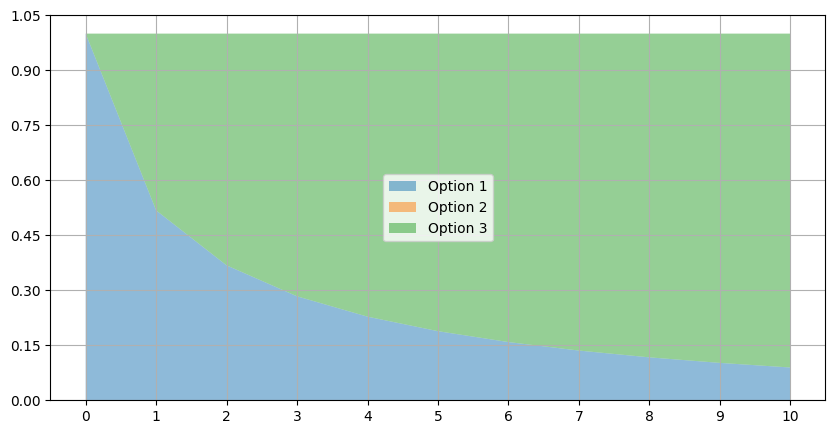


Bob
[ 0.000  1.000  0.000]
[ 0.000  0.600  0.400]
[ 0.000  0.476  0.524]
[ 0.000  0.406  0.594]
[ 0.000  0.360  0.640]
[ 0.000  0.327  0.673]
[ 0.000  0.302  0.698]
[ 0.000  0.283  0.717]
[ 0.000  0.268  0.732]
[ 0.000  0.255  0.745]
[ 0.000  0.245  0.755]


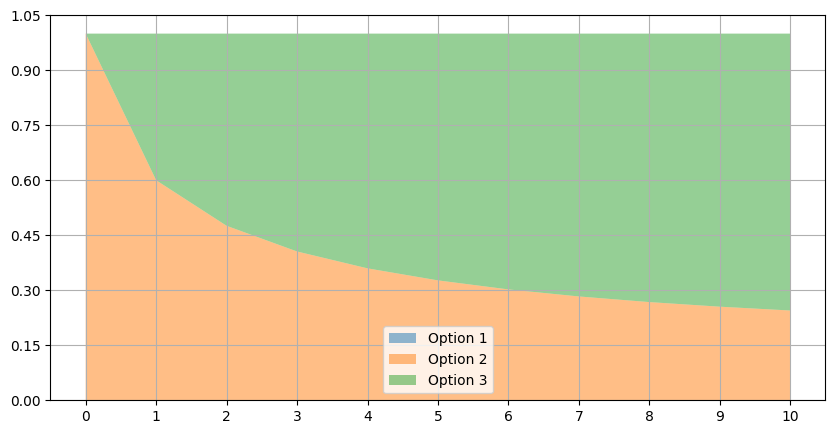

In [530]:
alice = [1, 0, 0]
bob   = [0, 1, 0]

communicate(alice, bob, 10)

## Same strong preferences
Observation: Preferences don't change, as expected

Initial joint preference
[[ 1.000  0.000  0.000]
 [ 0.000  0.000  0.000]
 [ 0.000  0.000  0.000]]

Alice
[ 1.000  0.000  0.000]
[ 1.000  0.000  0.000]
[ 1.000  0.000  0.000]
[ 1.000  0.000  0.000]


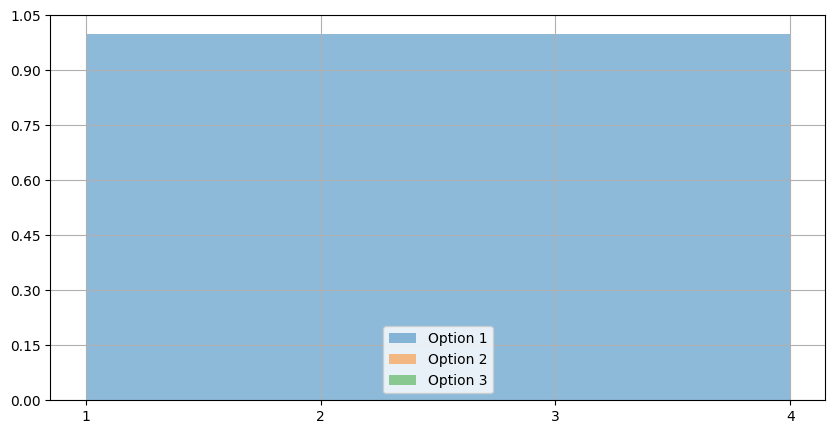


Bob
[ 1.000  0.000  0.000]
[ 1.000  0.000  0.000]
[ 1.000  0.000  0.000]
[ 1.000  0.000  0.000]


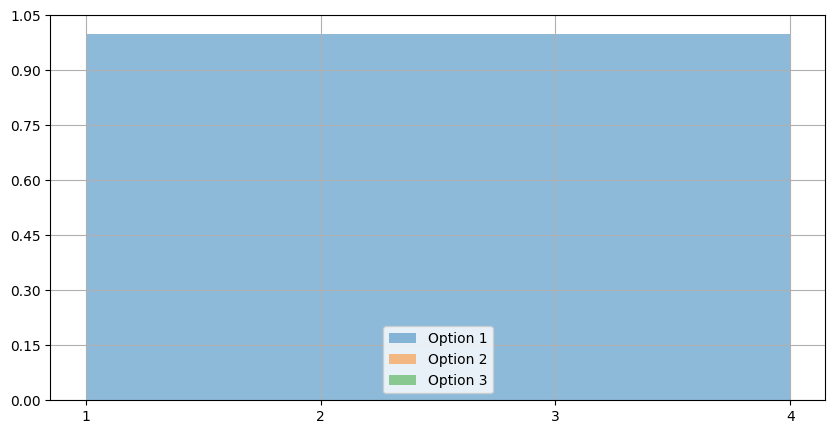

In [514]:
alice = [1, 0, 0]
bob   = [1, 0, 0]

communicate(alice, bob, 3)

## Same weaker preferences
Observations: 
- Both move towards third option

Initial joint preference
[[ 0.490  0.210  0.000]
 [ 0.210  0.090  0.000]
 [ 0.000  0.000  0.000]]

Alice
[ 0.700  0.300  0.000]
[ 0.599  0.199  0.202]
[ 0.536  0.146  0.317]
[ 0.494  0.113  0.393]
[ 0.463  0.090  0.447]
[ 0.440  0.073  0.487]
[ 0.422  0.060  0.518]
[ 0.408  0.050  0.542]
[ 0.397  0.042  0.562]
[ 0.387  0.035  0.577]
[ 0.380  0.030  0.590]


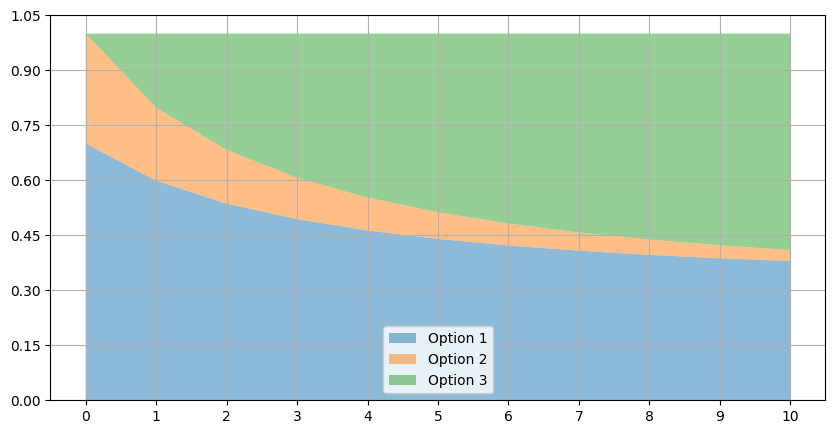


Bob
[ 0.700  0.300  0.000]
[ 0.553  0.216  0.231]
[ 0.476  0.164  0.359]
[ 0.428  0.129  0.443]
[ 0.394  0.104  0.502]
[ 0.369  0.084  0.546]
[ 0.351  0.070  0.580]
[ 0.336  0.058  0.606]
[ 0.324  0.048  0.627]
[ 0.315  0.041  0.645]
[ 0.307  0.034  0.659]


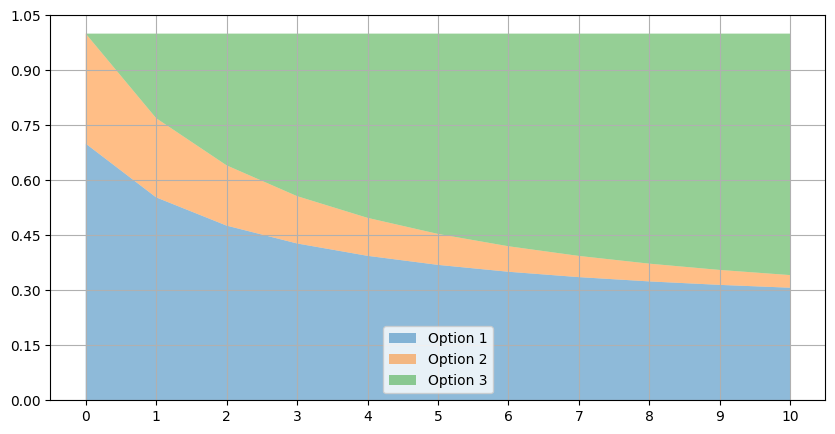

In [535]:
alice = [0.7, 0.3, 0]
bob   = [0.7, 0.3, 0]
communicate(alice, bob, 10)


### Alice's strong preference
Observations: 
- Bob keeps preference to Alice's opinion, his "other" option moves to third option
- Alice's preference moves heavily towards option 3, even though it shouldn't <== **PROBLEM?**
- Perhaps can be fixed by the same balancing of the transition matrix as in [Different strong preferences](#Different-strong-preferences)


Initial joint preference
[[ 0.300  0.700  0.000]
 [ 0.000  0.000  0.000]
 [ 0.000  0.000  0.000]]

Alice
[ 1.000  0.000  0.000]
[ 0.662  0.000  0.338]
[ 0.528  0.000  0.472]
[ 0.450  0.000  0.550]
[ 0.397  0.000  0.603]
[ 0.359  0.000  0.641]
[ 0.330  0.000  0.670]
[ 0.307  0.000  0.693]
[ 0.288  0.000  0.712]
[ 0.273  0.000  0.727]
[ 0.260  0.000  0.740]


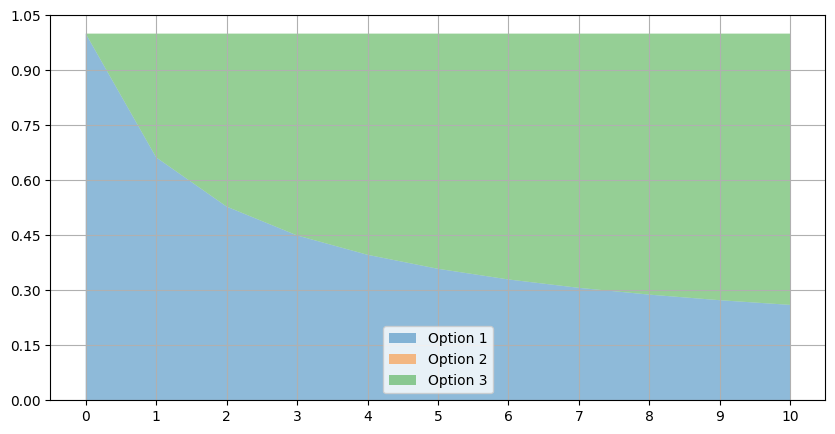


Bob
[ 0.300  0.700  0.000]
[ 0.300  0.420  0.280]
[ 0.300  0.309  0.391]
[ 0.300  0.244  0.456]
[ 0.300  0.200  0.500]
[ 0.300  0.168  0.532]
[ 0.300  0.144  0.556]
[ 0.300  0.125  0.575]
[ 0.300  0.110  0.590]
[ 0.300  0.097  0.603]
[ 0.300  0.086  0.614]


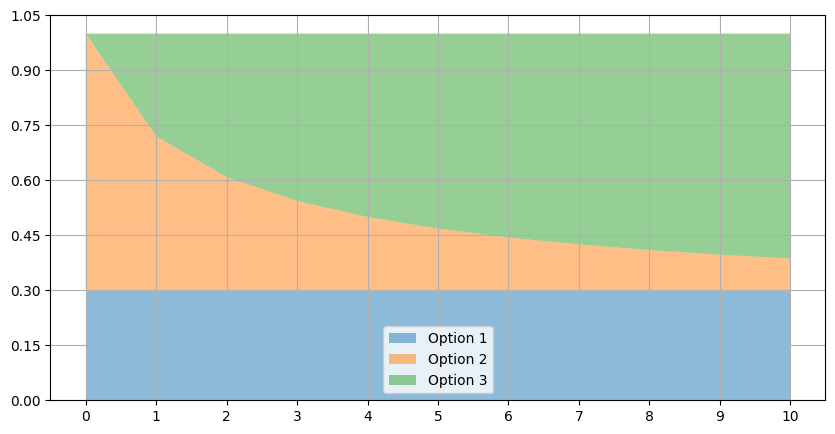

In [532]:
alice = [1, 0, 0]
bob   = [0.7, 0.3, 0]
communicate(alice, bob, 10)

# Original model

In [517]:
p = 1
q = 0.8
transition_orig = np.array([[p , 1 - p], [1 - q, q]])
print(transition_orig)

alice = [0.7, 0.3]
bob = [0, 1]

print("\nFrom")
joint = np.array([alice, bob])
print(joint)

result = np.dot(transition_orig, joint)

print("\nTo")
print(alice, "->", result[0])
print(bob, "->", result[1])



[[ 1.000  0.000]
 [ 0.200  0.800]]

From
[[ 0.700  0.300]
 [ 0.000  1.000]]

To
[0.7, 0.3] -> [ 0.700  0.300]
[0, 1] -> [ 0.140  0.860]


In [518]:
def t():
    return (1, 2)
arr = np.ndarray((3, 3))
arr[1, 2] = 10
arr[t()]


10.0

# Sandbox

[[ 0.700  0.300  0.000]
 [ 0.600  0.218  0.182]
 [ 0.548  0.166  0.286]
 [ 0.516  0.130  0.354]]

[[ 0.700  1.000  1.000]
 [ 0.600  0.818  1.000]
 [ 0.548  0.714  1.000]
 [ 0.516  0.646  1.000]]


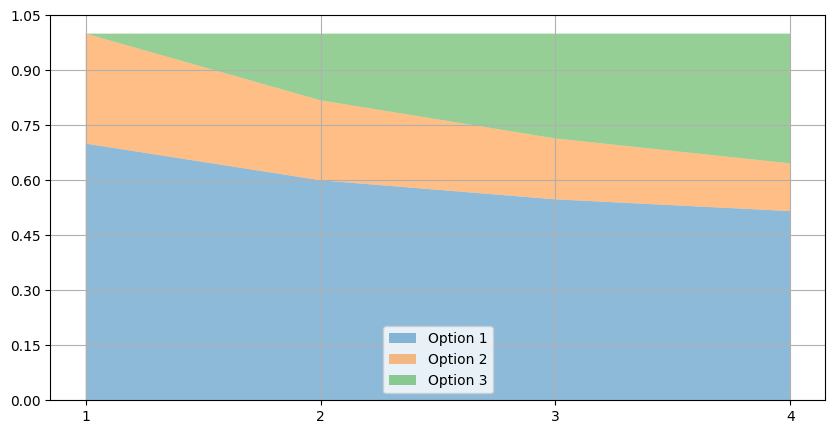

In [519]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
alice = np.array([[ 0.700,  0.300,  0.000],
[ 0.600, 0.218,  0.182],
[ 0.548,  0.166,  0.286],
[ 0.516,  0.130,  0.354]])

print(alice)
alice_cumsum = np.cumsum(alice, axis=1)
print()
print(alice_cumsum)

plt.figure(figsize=(10, 5))
x = np.arange(alice_cumsum.shape[0])
# plt.plot(alice_cumsum)
for i in range(3):
    baseline = 0 if i == 0 else alice_cumsum[:, i-1]    
    plt.fill_between(x, baseline, alice_cumsum[:, i], label=f'Option {i+1}', alpha=0.5)

plt.xticks(ticks=x, labels=[f'{i+1}' for i in x])

plt.legend()
plt.ylim(bottom=0)
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))
plt.grid()
plt.show()

# Archive

In [520]:
    # transition[locate((1, 2), (1, 2))] = np.random.rand() # Both keep their opinion
# transition[locate((1, 2), (1, 1))] = 0 # Alice persuades Bob
# transition[locate((1, 2), (2, 2))] = 0 # Bob persuades Alice
# transition[locate((1, 2), (2, 1))] = 0 # They persuade each other
# 
# # Impossible transitions
# transition[locate((1, 2), (3, 1))] = 0  # Alice persuades Bob and goes for option 3
# transition[locate((1, 2), (2, 3))] = 0 # Bob persuades Alice and goes for option 3
# 
# # third option transitions
# transition[locate((1, 2), (1, 3))] = np.random.rand() # Bob goes for option 3
# transition[locate((1, 2), (3, 2))] = np.random.rand() # Alice goes for option 3
# transition[locate((1, 2), (3, 3))] = np.random.rand() # Both go for option 3
# 
# # Different opinions, can't persuade each other
# transition[locate((2, 1), (2, 1))] = np.random.rand() # Both keep their opinion
# transition[locate((2, 1), (2, 2))] = 0 # Alice persuades Bob
# transition[locate((2, 1), (1, 1))] = 0 # Bob persuades Alice
# transition[locate((2, 1), (1, 2))] = 0 # They persuade each other
# 
# # Impossible transitions
# transition[locate((2, 1), (3, 2))] = 0 # Alice persuades Bob and goes for option 3
# transition[locate((2, 1), (1, 3))] = 0 # Bob persuades Alice and goes for option 3
# 
# # third option transitions
# transition[locate((2, 1), (2, 3))] = np.random.rand() # Bob goes for option 3
# transition[locate((2, 1), (3, 1))] = np.random.rand() # Alice goes for option 3
# transition[locate((2, 1), (3, 3))] = np.random.rand() # Both go for option 3

## Transition matrix setup

In [521]:
p = 0.5
q = 0.5
both = p*q
remain = 1 - p - q - both

pn = p / (p + q + both)
qn = q / (q + p + both)
bothn = both / (both + p + q)

print(pn, qn, bothn)
print(1 - pn - qn - bothn)

0.4 0.4 0.2
-5.551115123125783e-17
